<a href="https://colab.research.google.com/github/ceydaaseen/HumanActionRecognition/blob/main/Human_Action_Recognition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

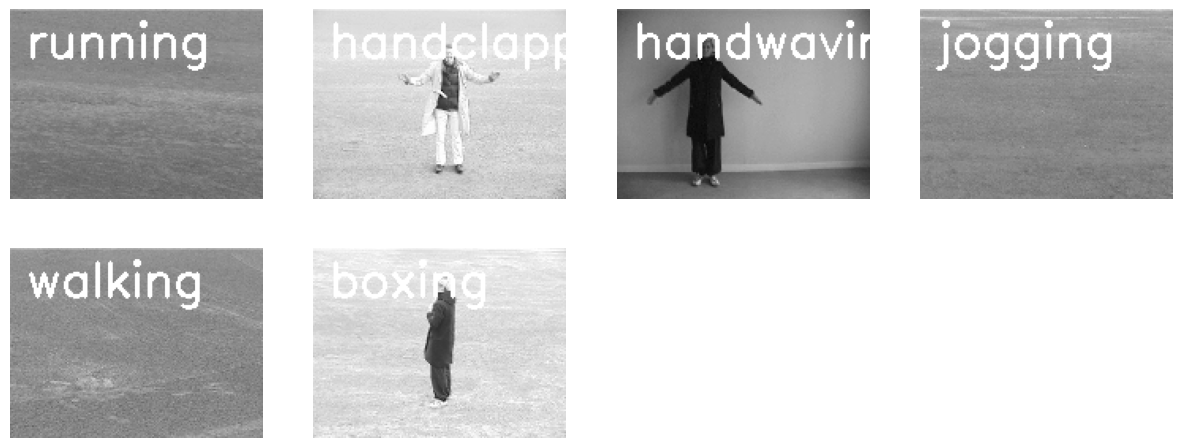

In [ ]:
plt.figure(figsize=(15,15))
dataset_path = '/content/drive/MyDrive/mpose_2021_dataset'
classes_names = ["walking", "jogging", "handwaving", "handclapping", "boxing", "running"]
#sınıflar için klasör yolu belirlenmesi
classes_paths = [os.path.join(dataset_path, cls) for cls in classes_names]
#sınıflara rastgele indeks atama
random_range = random.sample(range(len(classes_paths)),6)

for counter, random_index in enumerate(random_range, 1): #sınıflar için işlemlerin sırasıyla yapılması
  selected_class_name = classes_names[random_index] #rastgele seçilen sınıf isimlerinin alınması
  video_files_names_list = os.listdir(classes_paths[random_index]) #sınıfa ait dosyadaki videoların listelerinin alınması
  selected_video_file_name = random.choice(video_files_names_list) #sınıftan rastgele video seçilmesi
  video_reader = cv2.VideoCapture(os.path.join(classes_paths[random_index], selected_video_file_name)) #seçilen videonun okunması (ilk frame'in gösterilmesi için)

  _, bgr_frame = video_reader.read() #ilk karenin okunması
  video_reader.release() #video dosyasının kapatılması
  #bgr rbg format dönüşümü (opencv - matplotlib)
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  #görüntülerin sol üst kısmına sınıf ismi yazdırma
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
  #görüntünün çizdirilmesi , tek pencere
  plt.subplot(5,4,counter);
  plt.imshow(rgb_frame);
  plt.axis('off')

In [ ]:
image_height, image_width = 64, 64 #alınan kare boyutu
sequence_length = 20 #alınacak frame sayısı
dataset_directory = '/content/drive/MyDrive/mpose_2021_dataset' #veri seti dizin yolu
classes_list = ["walking", "jogging", "handwaving", "handclapping", "boxing", "running"]

In [ ]:
#boyutlandırma ve normalizasyon, listeye dönüşüm
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path) #opencv ile video dosyalarının açılması
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) #alınan toplam frame sayısı
  skip_frames_window = max(int(video_frames_count/sequence_length), 1) #toplam frame sayısı / istenen frame sayısı (kaçıncı frame'in alınacağı belirlenir)

  for frame_counter in range(sequence_length): #istenen aralıktaki karelerin alınması
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) #set() ile doğrudan belirli bir kareye gidilmesi
    success, frame = video_reader.read() #frame okunması

    if not success:
      break #video sonuna gelindiyse döngüden çıkılır
    resized_frame = cv2.resize(frame, (image_height, image_width)) #alınan kare boyutuna dönştürülmesi
    normalized_frame = resized_frame / 255 #0-1 aralığında normalizasyon (piksel değerleri için) yapılması, işlemlerin hızlanması için
    frames_list.append(normalized_frame) #hazırlanan frame'i listeye ekleme
  video_reader.release() #video dosyasının kapatılması
  return frames_list #kare listesine döndür

In [ ]:
#veri seti oluşturumu
def create_dataset():
  features=[]
  labels=[]
  video_files_paths=[]

  for class_index, class_name in enumerate(classes_list): #her sınıf için döngünün başlatılması, enumarate ile hem indeks hem isim alınması sağlanır
    print(f'Extracting Data of class: {class_name}')
    files_list = os.listdir(os.path.join(dataset_directory, class_name)) #tüm video dosyalarının listelenmesi
    for file_name in files_list: #her video için tam yol oluşturulması
      video_file_path = os.path.join(dataset_directory, class_name, file_name)
      frames = frames_extraction(video_file_path) #video dosyasından 20 frame'in çıkarılması ve işlenmesi
      if len(frames) == sequence_length:
        features.append(frames) #features'a frame dizisi eklenir
        labels.append(class_index) #sınıf inseksi labels'a eklenir
        video_files_paths.append(video_file_path) #video dosya yolu eklenir

  features = np.asarray(features) #liste verileri numpy dizisine dönüştürülür
  labels = np.array(labels)
  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of class: walking
Extracting Data of class: jogging
Extracting Data of class: handwaving
Extracting Data of class: handclapping
Extracting Data of class: boxing
Extracting Data of class: running


In [ ]:
one_hot_encoded_labels = to_categorical(labels) #format dönüşümü

In [ ]:
# train test = 0.3 - 0.7 olarak verilmişti, deneme 0.2-0.8 şeklinde yapılacak.
#random_state sonuçlar çalıştırıldığında aynı olacak (seed_constant ile)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():
  model = Sequential()  #katmanlar sırasıyla eklenecek, sıralı model oluşumu
  #1. convlstm katmanı, 4 filtreli 3x3'lük convlstm katmanı
  #return_sequences: sonraki katmanın zaman serisi bekleme durumu
  #ezberleme önlemek için dropout uygulandı
  #input shape: 20 frame 64x64 rgb video girdisi
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True, input_shape = (sequence_length,image_height, image_width, 3)))
  #havuzlama için max-poolig her framede 2x2 filtre
  #ezberleme olmaması için her zaman dropout uygulaması
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  #8 filtreli 3x3 cnvlstm katmanı
  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))
  #havuzlama her adımda 2x2'lik filtre
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.3, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  #matris vektör dönüşümünün flattening layer'da gerçekleştirilmesi
  model.add(Flatten())
  #liste uzunluğu kadar nöronlu ysa
  model.add(Dense(len(classes_list), activation = "softmax"))
  model.summary()
  return model


In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")
#model görselleştirildi

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
#optimizasyon algoritması Adam,batch_size=16 , 100 epoch, patience=90, min kayıp bekleniyor, en iyideki ağırlıklar geri yüklenecek(ezberleme olmaması için)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 90, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 16 ,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.1894 - loss: 1.7965 - val_accuracy: 0.1354 - val_loss: 1.7878
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.1826 - loss: 1.7896 - val_accuracy: 0.1250 - val_loss: 1.7687
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.2589 - loss: 1.6363 - val_accuracy: 0.3646 - val_loss: 1.3877
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - accuracy: 0.3549 - loss: 1.2669 - val_accuracy: 0.3542 - val_loss: 1.1986
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.4233 - loss: 1.1288 - val_accuracy: 0.3646 - val_loss: 1.1035
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.4229 - loss: 1.0738 - val_accuracy: 0.3750 - val_loss: 1.1059
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.4708 - loss: 1.0319 - val_accuracy: 0.4167 - val_loss: 1.0095
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.4357 - loss: 1.0159 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Sınıflandırma Raporu:

              precision    recall  f1-score   support

     walking       0.52      0.46      0.49        24
     jogging       0.21      0.28      0.24        18
  handwaving       0.79      0.58      0.67        19
handclapping       0.76      0.68      0.72        19
      boxing       0.63      1.00      0.77        12
     running       0.48      0.43      0.45        28

    accuracy                           0.53       120
   macro avg       0.57      0.57      0.56       120
weighted avg       0.56      0.53      0.54       120



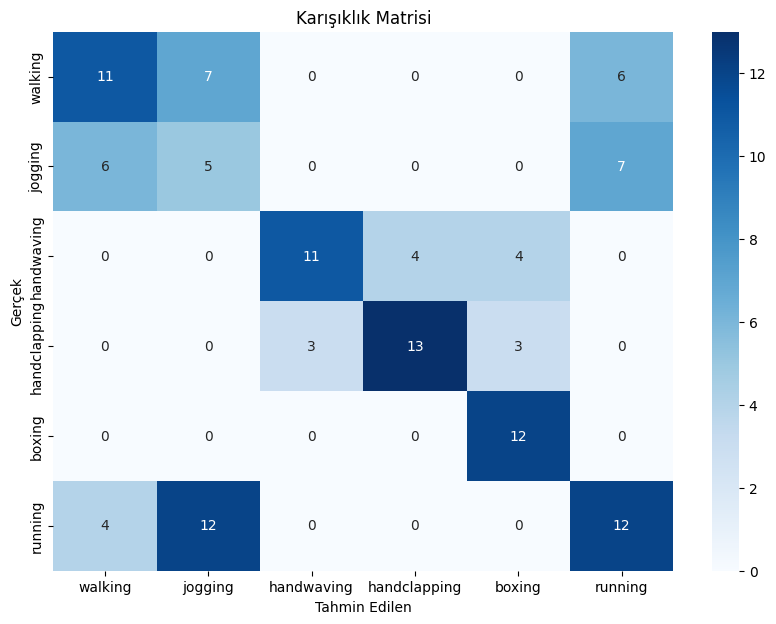

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# test verisi ile tahmin yapılsın
predictions = convlstm_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

# sınıf isimleri
classes_list = ["walking", "jogging", "handwaving", "handclapping", "boxing", "running"]

print("Sınıflandırma Raporu:\n")
print(classification_report(true_labels, predicted_labels, target_names=classes_list))

# Karışıklık Matrisi
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5248 - loss: 1.2790


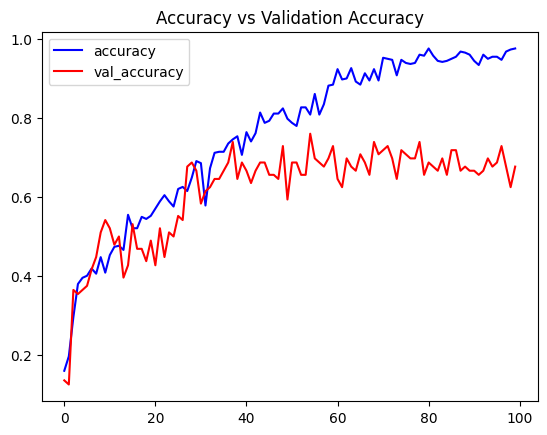

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # metric değerlerini al
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # epoch sayısını belirle, metrik1 uzunluğunda

    epochs = range(len(metric_value_1))

    # plot oluştur
    plt.plot(epochs, metric_value_1, 'b', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'r', label = metric_name_2)

    # başlık ve legend
    plt.title(plot_name)
    plt.legend()
    plt.show()

plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')


In [ ]:
def create_LRCN_model():
  model = Sequential()
  #time_distributed: her görüntü için yapılır, padding = same : giriş ve çıkış boyutları aynı olmalıdır
  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'), input_shape = (sequence_length, image_height, image_width, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32)) #32 boyutlu lstm katmanı
  model.add(Dropout(0.25))
  model.add(Dense(len(classes_list), activation = "softmax"))
  model.summary()
  return model


In [ ]:
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,126 (285.65 KB)

 Trainable params: 73,126 (285.65 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 90, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 16 ,shuffle = True,
                                             validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.1422 - loss: 1.8255 - val_accuracy: 0.1250 - val_loss: 1.7923
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2065 - loss: 1.7839 - val_accuracy: 0.1250 - val_loss: 1.7743
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1858 - loss: 1.7156 - val_accuracy: 0.4167 - val_loss: 1.3464
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.2878 - loss: 1.3184 - val_accuracy: 0.3750 - val_loss: 1.2062
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3479 - loss: 1.2220 - val_accuracy: 0.3646 - val_loss: 1.1221
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3645 - loss: 1.1718 - val_accuracy: 0.3854 - val_loss: 1.1064
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3389 - loss: 1.1571 - val_accuracy: 0.3854 - val_loss: 1.0854
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3512 - loss: 1.1334 - val_accuracy: 0.4271 - v

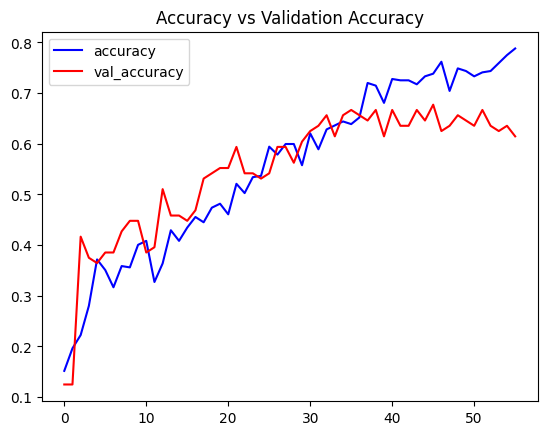

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')